In [42]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
words = open('names.txt', 'r').read().splitlines()
chars = ['.'] + sorted(list(set("".join(words))))
vocab_size = len(chars)

stoi = {char:i for i, char in enumerate(chars)}
itos = {i: char for char, i  in stoi.items()}

print(len(words))
print(vocab_size)

32033
27


In [44]:
block_size = 6

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [45]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')    

In [46]:
embed_size = 10
hidden_size = 300

E = torch.randn((vocab_size, embed_size))
W1 = torch.randn((embed_size*block_size, hidden_size))  * (5/3) / ((embed_size*block_size)**0.5)
W2 = torch.randn((hidden_size, vocab_size)) * 0.1           
b2 = torch.randn(vocab_size) * 0.1    

bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

bngain = torch.randn((1, hidden_size)) * 0.1 + 0.1
bnbias = torch.randn((1, hidden_size)) * 0.1
parameters = [E, W1, W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad = True

In [47]:
params = sum(p.nelement() for p in parameters)
params

26997

In [48]:
batch_size = 64
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (n, ))
Xb, Yb = Xtr[ix], Ytr[ix]

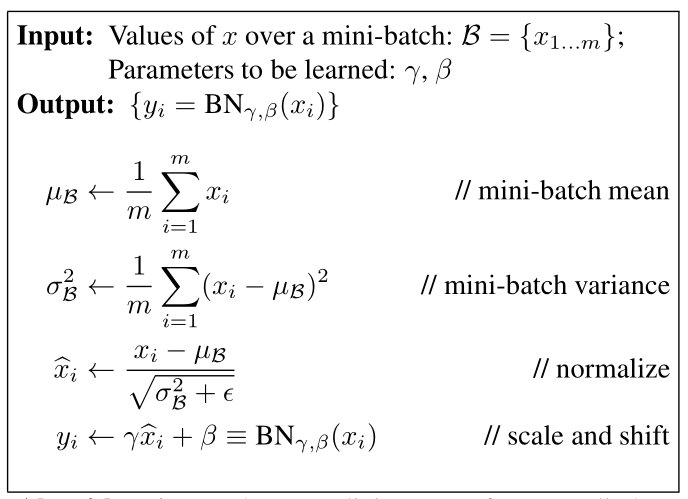

In [56]:
# forward pass 

# Linear layer
emb = E[Xb]
embcat = emb.view(emb.shape[0], -1)
hprebn = embcat @ W1 # 64 x 300 demb

# Batch Normalization layer 
bnmeani = 1/n * hprebn.sum(0, keepdim=True) 
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain*bnraw + bnbias

# Tanh 
h = torch.tanh(hpreact)
logits = h @ W2 + b2

# .softmax()
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
print(counts_sum_inv.shape)
print(counts.shape)

probs = counts * counts_sum_inv
logprobs = probs.log()

# Loss
loss = -logprobs[range(n), Yb].mean()


for p in parameters:
    p.grad = None
    
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts,
          norm_logits,logit_maxes,logits, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff,h , bnmeani, hprebn,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss


torch.Size([64, 1])
torch.Size([64, 27])


tensor(3.4276, grad_fn=<NegBackward0>)

In [125]:
# Ex.1 - Backprop through the whole thing manually 

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = dlogprobs/probs

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# dcounts = counts_sum_inv*dprobs
dcounts_sum = (-1/counts_sum**2)* dcounts_sum_inv 
dcounts =  (torch.ones_like(counts)) * dcounts_sum + counts_sum_inv * dprobs
dnorm_logits = counts * dcounts
dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)
dlogits = dnorm_logits.clone()
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = dh * (torch.ones_like(h) - h**2)
dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
dbnraw = (dhpreact*bngain)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnvar_inv =  (bndiff * dbnraw).sum(0)
dbnvar = (0.5*(bnvar + 1e-5)**-0.5) * dbnvar_inv 
dbndiff2 = torch.ones_like(bndiff2)/(n-1) * dbnvar
dbndiff = (2 * bndiff) *dbndiff2 + dbnraw*bnvar_inv
dbnmeani = (-1.0*dbndiff).sum(0) 
dhprebn = dbndiff.clone() + torch.ones_like(hprebn)/n * dbnmeani 
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
demb = dembcat.view(batch_size, block_size, embed_size)
dE = torch.zeros_like(E)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dE[ix] += demb[k, j]
    
    
    
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('emb', demb, emb)
cmp('E', dE, E)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
h               | exact: False | approximate: True  | maxdiff: 1.280568540096283e-09
W2              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
b2              | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
hpreact         | exact: False | approximate: True  | maxdiff: 1.2223608791828156e-09
bngain          | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
bnbias          | 